In [33]:
%matplotlib inline

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from utils import *
from gtv import *

# GTV for climate forecasting

This walkthrough demonstrates the basic functionality of the GTV forecasting system. I am still working cleaning up the rest of the code, but hopefully this is enough to get started!

The objective function GTV solves is as follows:

$$ \hat{\beta} = \text{argmin}_\beta \left \{ \| y - X\beta \|_2^2  + \lambda_1 \| \beta \|_1 + \lambda_{TV} \| \Gamma \beta \|_1 \right\} $$

where $\Gamma$ is the [edge-incidence matrix](https://en.wikipedia.org/wiki/Incidence_matrix) of the graph induced by some covariance matrix. In our paper, we use the thresholded covariance matrix of Pacific SSTs from the 40 [CESM Large Ensembles](http://www.cesm.ucar.edu/projects/community-projects/LENS/). 


First, here's a very simple example that demonstrates the mechanics of the GTV library.

In [25]:
# load data and compute covariance matrix
X = pd.read_csv('data/X_obs.csv').values
y = pd.read_csv('data/y_avg.csv').values.reshape(1,-1)[0]
Xlens = pd.read_csv('data/X_lens.csv').values
fts = pd.read_csv('data/sst_columns.csv')

Slens = Xlens.T@Xlens/Xlens.shape[0]
Dlens = edge_incidence(Slens, .5) # we threshold the covariance matrix at .5

# split data into train/test
X_train = X[:50]
y_train = y[:50]
X_test = X[50:]
y_test = y[50:]

Now we solve the GTV objective and plot the solution:

In [29]:
# solve GTV for a specified pair of regularization parameters (these aren't optimal just a pair that works)
beta = gtv_cvx(X_train, y_train, Dlens, lambda_lasso=.3, lambda_tv=.01, alpha=.9)
print(r2_score(y_test, X_test@beta))

0.4415110306872633


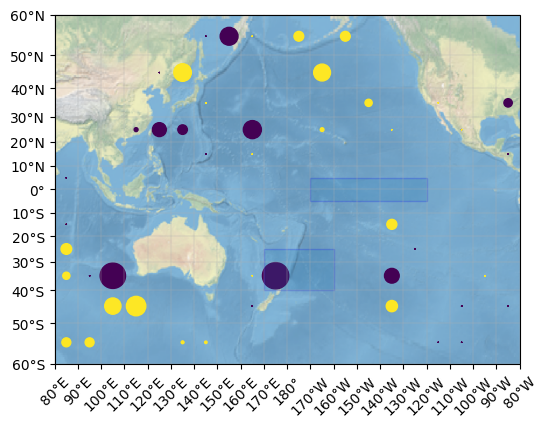

In [30]:
# plot the solution
fts['coef'] = beta
plot_coefs(fts)

We can compute errors over an array of regularization parameters and plot them (these get slow to run):

In [32]:
df = gtv_cvx_path(X, y, Dlens, np.linspace(.01, 1, 10), np.logspace(-3, -1, 10), alpha=.9)

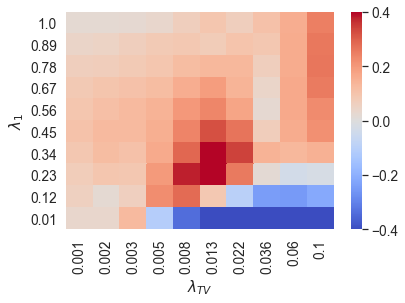

In [37]:
draw_lambda_contour(df.round(3), 'r2', vmin=-.4, vmax=.4)